In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train.reshape(-1, 28, 28, 1))


In [ ]:

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)  
        a = tf.keras.backend.softmax(e, axis=1)  
        output = x * a
        return tf.keras.backend.sum(output, axis=1) 

In [ ]:

inputs = Input(shape=(28, 28))   
gru_out = GRU(128, return_sequences=True)(inputs)
att_out = Attention()(gru_out)
dense1 = Dense(64, activation="relu")(att_out)
outputs = Dense(10, activation="softmax")(dense1)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 28, 128)        │        60,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,734 (272.40 KB)

 Trainable params: 69,734 (272.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_test, y_test)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.5844 - loss: 1.1384 - val_accuracy: 0.7870 - val_loss: 0.5782
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 0.8076 - loss: 0.5265 - val_accuracy: 0.8223 - val_loss: 0.4739
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.8362 - loss: 0.4368 - val_accuracy: 0.8443 - val_loss: 0.4246
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.8540 - loss: 0.3922 - val_accuracy: 0.8525 - val_loss: 0.3982
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 96ms/step - accuracy: 0.8631 - loss: 0.3671 - val_accuracy: 0.8588 - val_loss: 0.3738


In [ ]:

loss, acc = model.evaluate(x_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8580 - loss: 0.3716
✅ Test Accuracy: 0.8588


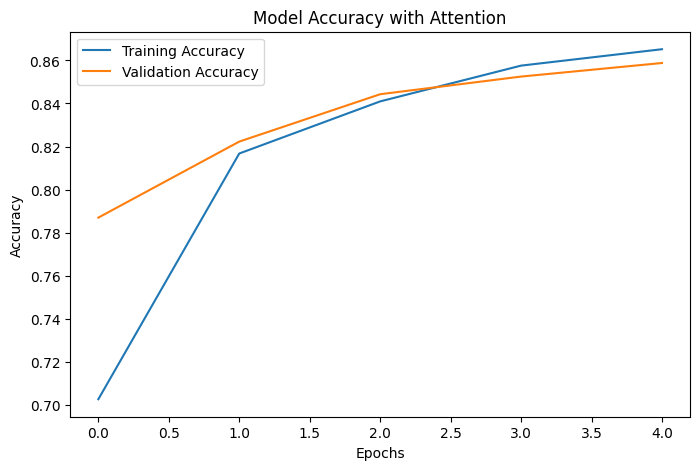

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy with Attention")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

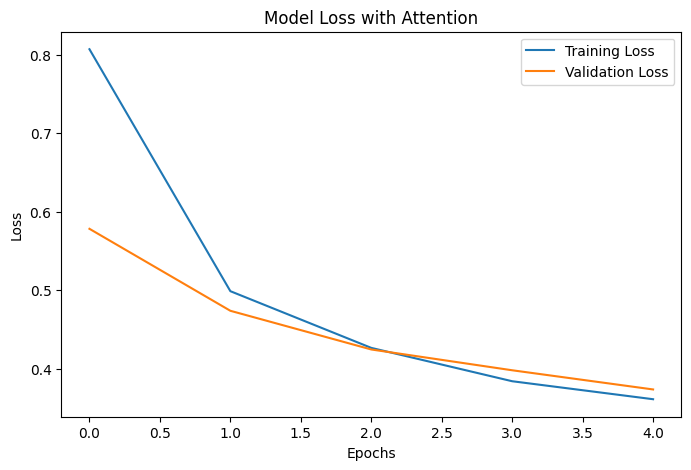

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss with Attention")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()